# Gaussian Process regression Hemocell analysis

In [1]:
import numpy as np
import pandas as pd

from lxml import etree

import matplotlib.pyplot as plt

from scipy.stats import norm,truncnorm,uniform,multivariate_normal

from SALib.sample import saltelli
from SALib.analyze import sobol

import tqdm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel,WhiteKernel

import statsmodels.api as sm

import UQLib.calibration.TMCMC as TMCMC

from local_config import *

titlefontsize = 24
axisfontsize = 24
labelfontsize = 20

plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18

# Seed used for Master Thesis
np.random.seed(6345789)

In [2]:
names = {"kLink":r"$\kappa_l$","kBend":r"$\kappa_b$",
         "viscosityRatio":r"$\Lambda$","err":r"$\sigma^m$",
         "shearrate":r"$\dot{\gamma}$"}

## Load training data

In [3]:
# Load simulation data
mode="visc"

imin = 0
imax = 10

# Load simulation data
x_train = np.load("%s/train_hemocell_samples_%s_%i_%i.npy" % (outputpath,mode,imin,imax))
y_train = np.load("%s/train_hemocell_qoi_%s_%i_%i.npy" % (outputpath,mode,imin,imax))
c_err = np.load("%s/train_hemocell_c_err_%s_%i_%i.npy" % (outputpath,mode,imin,imax))

x_fail = x_train[y_train[:,0] < 0,:-3]

# Remove failed simulation outputs
x_train = x_train[y_train[:,0] >= 0,:-3]
c_err = c_err[y_train[:,0] >= 0]
y_train = y_train[y_train[:,0] >= 0]

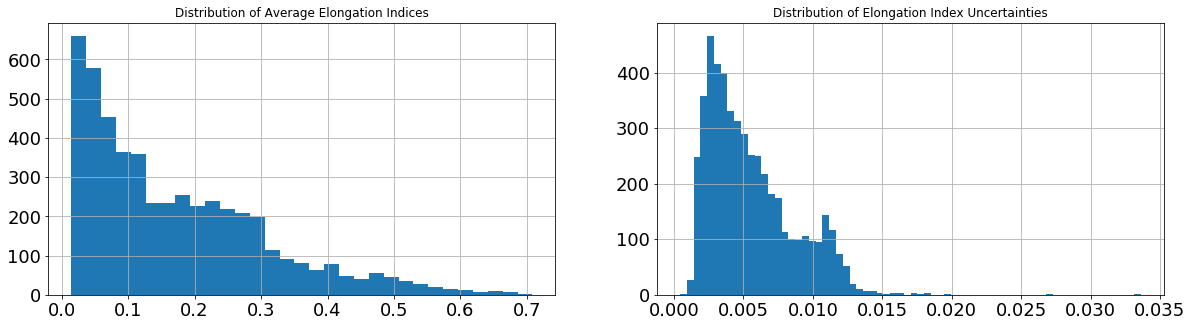

In [4]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.title("Distribution of Average Elongation Indices")
plt.grid(True)
plt.hist(y_train,bins='auto')

plt.subplot(1,2,2)
plt.title("Distribution of Elongation Index Uncertainties")
plt.grid(True)
plt.hist(c_err,bins='auto')
plt.show()

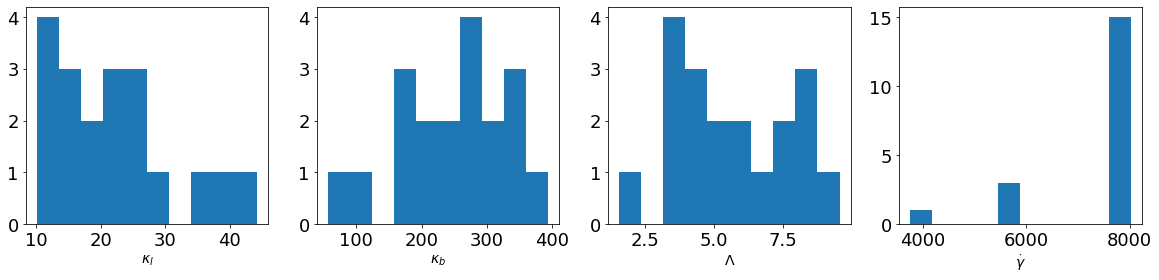

[[1.04376184e+01 3.40380112e+02 3.73208103e+00 3.76053215e+03]
 [1.39042694e+01 2.94625541e+02 7.30811798e+00 5.49002217e+03]
 [2.31973826e+01 1.63810966e+02 3.38292797e+00 5.49002217e+03]
 [2.23744680e+01 5.62990190e+01 4.83929383e+00 5.49002217e+03]
 [3.45660501e+01 2.63656543e+02 3.79682998e+00 8.01773836e+03]
 [1.83900561e+01 2.88338784e+02 6.72501492e+00 8.01773836e+03]
 [2.57752660e+01 2.97697905e+02 8.35316019e+00 8.01773836e+03]
 [1.18441405e+01 2.68337524e+02 5.17894894e+00 8.01773836e+03]
 [1.80835418e+01 3.55916214e+02 4.52639444e+00 8.01773836e+03]
 [1.39079445e+01 1.81466726e+02 1.56982462e+00 8.01773836e+03]
 [2.10134854e+01 2.50621915e+02 6.10036263e+00 8.01773836e+03]
 [4.42884862e+01 3.50236850e+02 4.26866290e+00 8.01773836e+03]
 [2.38810157e+01 1.75394634e+02 6.25203931e+00 8.01773836e+03]
 [2.69631770e+01 2.22090553e+02 3.69226897e+00 8.01773836e+03]
 [1.58792869e+01 2.41985919e+02 8.07443625e+00 8.01773836e+03]
 [1.24274551e+01 3.94301693e+02 9.56855639e+00 8.017738

In [5]:
plt.figure(figsize=(20,4))

params = ["kLink","kBend","viscosityRatio","shearrate"]
for n in range(x_fail.shape[1]):
    plt.subplot(1,4,n+1)
    plt.xlabel(names[params[n]],fontsize=14)
    plt.hist(x_fail[:,n])

plt.show()

print(x_fail)

## Train prediction model

In [6]:
# Set global variables training model
gpType = "multi"
isotropic = True

modelType = gpType + "_GP_"
if isotropic:
    modelType = modelType + "isotropic"
else:
    modelType = modelType + "anisotropic"
    
print("Chosen model type:", modelType)

Chosen model type: multi_GP_isotropic


In [7]:
def singleModel(x_train,y_train,n_restarts=0,isotropic=True):
    
    if isotropic:
        length_scale = 1.0
    else:
        length_scale = np.ones(x_train.shape[1])
    
    kernel = RBF(length_scale) + WhiteKernel()
    return GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=n_restarts).fit(x_train,y_train)

def multipleModels(x_train,y_train,n_restarts=0,isotropic=True):
    params,shearrates = x_train[:,:-1],x_train[:,-1]
    
    if isotropic:
        length_scale = 1.0
    else:
        length_scale = np.ones(params.shape[1])
        
    kernels = {shearrate : RBF(length_scale) + WhiteKernel() for shearrate in np.unique(shearrates)}
    
    predictionModels = {}
    for shearrate in np.unique(shearrates):
        model = GaussianProcessRegressor(kernel=kernels[shearrate],
                                         n_restarts_optimizer=n_restarts).fit(params[shearrate == shearrates],
                                                                              y_train[shearrate == shearrates])
        
        predictionModels[shearrate] = model
        
    return predictionModels
    

# Train prediction model
if gpType == "multi":
    %time model = multipleModels(x_train,y_train,n_restarts=10,isotropic=isotropic)
elif gpType == "single":
    %time model = singleModel(x_train,y_train,n_restarts=1,isotropic=isotropic)

CPU times: user 58.1 s, sys: 4.73 s, total: 1min 2s
Wall time: 1min 3s


In [8]:
def predictionModel(x,return_std=False):
    if type(model) is dict:
        return model[x[0,-1]].predict(x[:,:-1],return_std=return_std)
    else:
        return model.predict(x,return_std=return_std)

## Test prediction model

In [9]:
imin = 2
imax = 10

# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_full.csv" % (datapath),sep=";")
data = data.loc[data["Treatment"] == 0.5]
stress,el,el_err = data.values[imin:imax,[1,2,3]].T

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

# Compute the shear rates
shearrate = stress / (nuP * rhoP)

model_params = ["kLink","kBend","viscosityRatio"]

# Set the bounds on the parameters
bounds = [[10.0,300.0],
          [50.0,400.0],
          [1.0,15.0]
         ]

# Problem for Sobol analysis
sobol_problem = {"num_vars":3,
                 "names":model_params,
                 "bounds":bounds
                }

param_values = saltelli.sample(sobol_problem,1000,calc_second_order=False)
sobol_qoi = np.load("%s/sobol_hemocell_qoi_%s_%i_%i.npy" % (outputpath,mode,imin,imax))

idx_fail = np.where(sobol_qoi < 0)
idx_success = np.where(sobol_qoi >= 0)

x_fail = np.column_stack([param_values[idx_fail[0]],shearrate[idx_fail[1]]])
x_success = np.column_stack([param_values[idx_success[0]],shearrate[idx_success[1]]])

In [10]:
sobol_predictions = np.empty(sobol_qoi[idx_success].shape)

with tqdm.tqdm(total=sobol_predictions.size) as pbar:
    for n in range(sobol_predictions.size):
        sobol_predictions[n] = predictionModel(x_success[n][None,:])
        pbar.update()

S_err = np.sum((sobol_qoi[idx_success] - sobol_predictions)**2)
S_test = np.sum((np.mean(sobol_qoi[idx_success]) - sobol_qoi[idx_success])**2)

Q2 = 1 - S_err / S_test

print("Predictivity coefficient:",Q2)

100%|██████████| 39816/39816 [00:08<00:00, 4877.65it/s]

Predictivity coefficient: 0.9976394063206563


## Test performance of metamodel

In [11]:
test_params = np.column_stack([np.tile(np.array([120,80,5])[None,:],(shearrate.size,1)),shearrate])

In [12]:
"""
for n in range(shearrate.size):
    print("Shear stress: %f, Shear rate: %f" % (stress[n],shearrate[n]))
    %timeit -n 100 -r 100 predictionModel(test_params[n][None,:],return_std=True)
"""

'\nfor n in range(shearrate.size):\n    print("Shear stress: %f, Shear rate: %f" % (stress[n],shearrate[n]))\n    %timeit -n 100 -r 100 predictionModel(test_params[n][None,:],return_std=True)\n'

## Sentivity Analysis

In [13]:
imin = 0
imax = 10

# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_full.csv" % (datapath),sep=";")
data = data.loc[data["Treatment"] == 0.5]
stress = data.values[imin:imax,1]

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

In [14]:
nsamples = 10000

model_params = ["kLink","kBend","viscosityRatio"]

# Compute the shear rates
shearrate = stress / (nuP * rhoP)

# Set the bounds on the parameters
bounds = [[10.0,300.0],
          [50.0,400.0],
          [1.0,15.0]
         ]

# Problem for Sobol analysis
sobol_problem = {"num_vars":3,
                 "names":model_params,
                 "bounds":bounds
                }

param_values = saltelli.sample(sobol_problem,nsamples,calc_second_order=False)

sobol_qoi = np.zeros((param_values.shape[0],shearrate.size))

with tqdm.tqdm(total=sobol_qoi.size) as pbar:
    for n,param_set in enumerate(param_values):
        for m,design_val in enumerate(shearrate):
            arr = np.array([*param_values[n],design_val])[None,:]
            mean = predictionModel(arr)

            sobol_qoi[n,m] = mean
            
            pbar.update()

100%|██████████| 500000/500000 [01:50<00:00, 4521.26it/s]


In [15]:
# Get the sobol indices
sobol_indices = [sobol.analyze(sobol_problem,sobol_qoi[:,m],
                               calc_second_order=False) for m in range(shearrate.size)]

S1 = np.array([sobol_indices[m]["S1"] for m in range(shearrate.size)]).T
ST = np.array([sobol_indices[m]["ST"] for m in range(shearrate.size)]).T

S1_conf = np.array([sobol_indices[m]["S1_conf"] for m in range(shearrate.size)]).T
ST_conf = np.array([sobol_indices[m]["ST_conf"] for m in range(shearrate.size)]).T

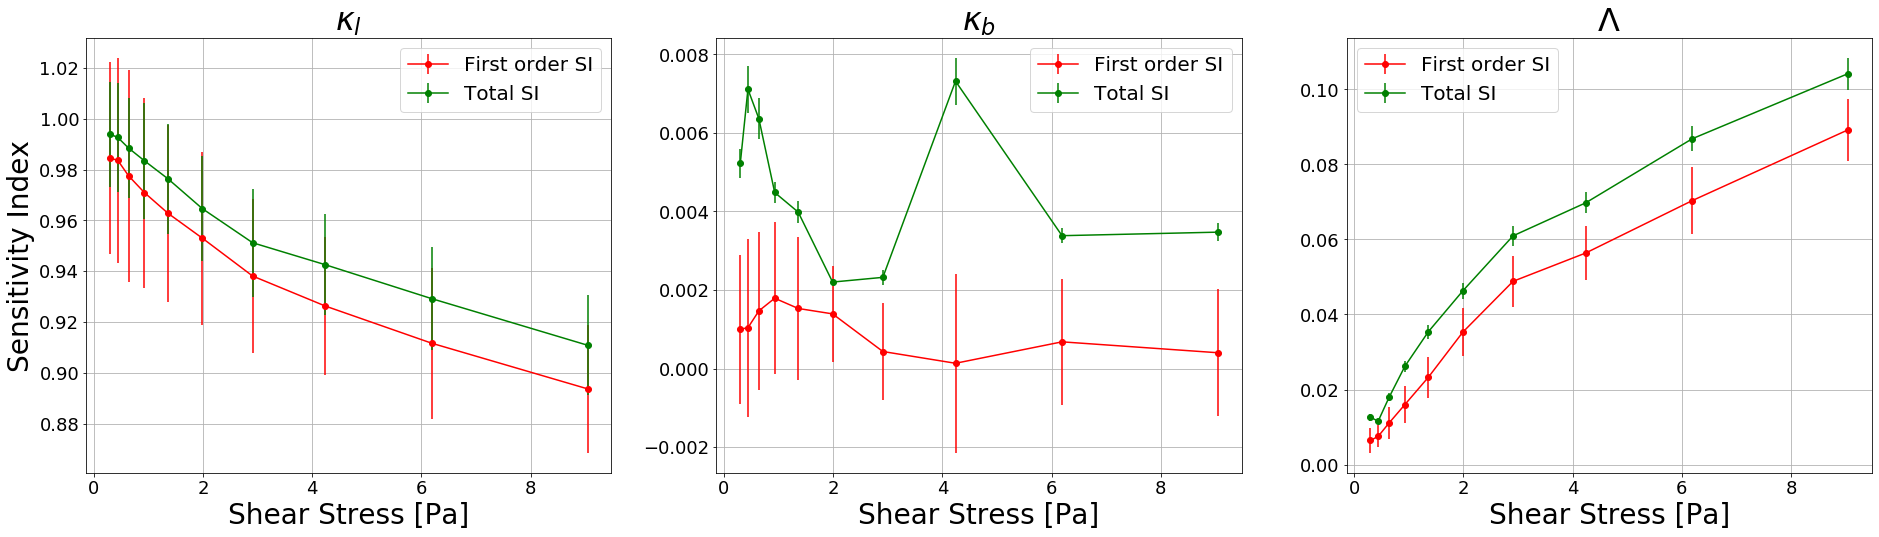

In [16]:
plt.figure(figsize=(32,8))
for n in range(len(model_params)):
    plt.subplot(1,3,n+1)
    plt.title(names[model_params[n]],fontsize=32)
    plt.grid(True)
    plt.xlabel("Shear Stress [Pa]",fontsize=28)
    
    if n == 0:
        plt.ylabel("Sensitivity Index",fontsize=28)
    
    plt.errorbar(stress,S1[n],yerr=S1_conf[n],color="red",fmt="o-",label="First order SI")
    plt.errorbar(stress,ST[n],yerr=ST_conf[n],color="green",fmt="o-",label="Total SI")
    
    plt.legend(fontsize=labelfontsize)

plt.show()

## Setup TMCMC sampling

Bounds used in paper:
* $\kappa_l \in [10,300]$
* $\kappa_b \in [50,400]$
* $\Lambda \in [1,15]$
* $\sigma^m \in [0.001,0.1]$


In [17]:
def evaluate_GP(params):
    kLink = params["kLink"]
    kBend = params["kBend"]
    viscosityRatio = params["viscosityRatio"]
    shearrate = params["shearrate"]
    
    arr = np.array([kLink,kBend,viscosityRatio,shearrate])[None,:]
    mean,std = predictionModel(arr,return_std=True)
    return mean[0],std[0]

def model_prior(sample,enableInteriorViscosity):
    kLink_prior = uniform.pdf(sample[0],10.0,290.0)
    kBend_prior = uniform.pdf(sample[1],50.0,350.0)
    
    # Test prior
    #kLink_prior = uniform.pdf(sample[0],10.0,70.0)
    
    if enableInteriorViscosity:
        viscosityRatio_prior = uniform.pdf(sample[2],1.0,14.0)
        return np.prod([kLink_prior,kBend_prior,viscosityRatio_prior])
    else:
        return np.prod([kLink_prior,kBend_prior])

def model_sampler(nsamples,enableInteriorViscosity):
    kLink_samples = np.random.uniform(10.0,300.0,nsamples)
    kBend_samples = np.random.uniform(50.0,400.0,nsamples)
    
    # Test prior
    #kLink_samples = np.random.uniform(10.0,80.0,nsamples)
    
    if enableInteriorViscosity:
        viscosityRatio_samples = np.random.uniform(1.0,15.0,nsamples)
        return np.column_stack([kLink_samples,kBend_samples,viscosityRatio_samples])
    else:
        return np.column_stack([kLink_samples,kBend_samples])

def model_prior_gaussian(sample,enableInteriorViscosity):
    a,b,mean,std = 10,300,40,20
    kLink_prior = truncnorm.pdf(sample[0],(a-mean)/std,(b-mean)/std,loc=mean,scale=std)
    
    a,b,mean,std = 50,400,320,100
    kBend_prior = truncnorm.pdf(sample[1],(a-mean)/std,(b-mean)/std,loc=mean,scale=std)
    
    if enableInteriorViscosity:
        a,b,mean,std = 1,15,5,3
        viscosityRatio_prior = truncnorm.pdf(sample[2],(a-mean)/std,(b-mean)/std,loc=mean,scale=std)
        return np.prod([kLink_prior,kBend_prior,viscosityRatio_prior])
    else:
        return np.prod([kLink_prior,kBend_prior])

def model_sampler_gaussian(nsamples,enableInteriorViscosity):
    a,b,mean,std = 10,300,40,20
    kLink_samples = truncnorm.rvs((a-mean)/std,(b-mean)/std,loc=mean,scale=std,size=nsamples)
    
    a,b,mean,std = 50,400,320,100
    kBend_samples = truncnorm.rvs((a-mean)/std,(b-mean)/std,loc=mean,scale=std,size=nsamples)
    
    if enableInteriorViscosity:
        a,b,mean,std = 1,15,5,3
        viscosityRatio_samples = truncnorm.rvs((a-mean)/std,(b-mean)/std,loc=mean,scale=std,size=nsamples)
        return np.column_stack([kLink_samples,kBend_samples,viscosityRatio_samples])
    else:
        return np.column_stack([kLink_samples,kBend_samples])
    
def error_prior(sample):
    return np.prod(uniform.pdf(sample,0.001,0.099))
    
    # Test prior
    #return np.prod(uniform.pdf(sample,0.0,0.1))

def error_sampler(nsamples):
    return np.random.uniform(0.001,0.1,(nsamples,1))
    
    # Test prior
    #return np.random.uniform(0.0,0.1,(nsamples,1))

## Sanity Check

### Healthy

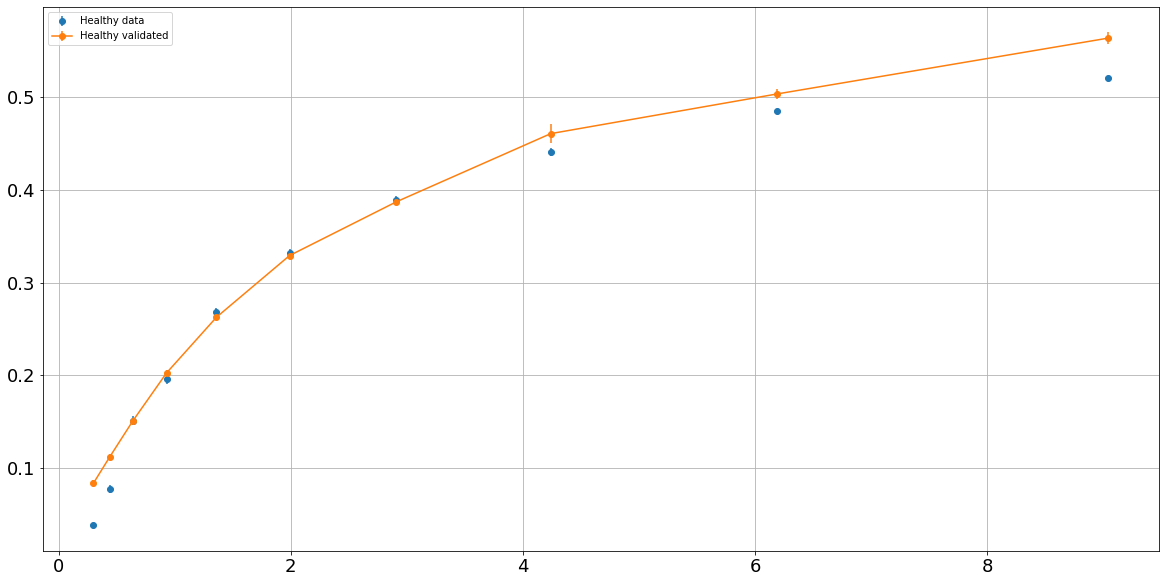

In [18]:
imin = 0
imax = 10

# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_full.csv" % (datapath),sep=";")
data = data.loc[data["Treatment"] == 0]
stress,el,el_err = data.values[imin:imax,[1,2,3]].T

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

shearrate = stress / (nuP * rhoP)

healthy_samples = np.zeros((shearrate.shape[0],x_train.shape[1]))

healthy_samples[:,:-1] = np.array([40,250,5])
healthy_samples[:,-1] = shearrate

healthy_qoi = np.empty(shearrate.shape[0])
healthy_std = np.empty(shearrate.shape[0])
for n in range(healthy_qoi.size):
    healthy_qoi[n],healthy_std[n] = predictionModel(healthy_samples[n][None,:],return_std=True)

plt.figure(figsize=(20,10))

plt.errorbar(stress,el,yerr=el_err,fmt='o',label="Healthy data")
plt.errorbar(stress,healthy_qoi,yerr=healthy_std,fmt='o-',label="Healthy validated")

plt.grid(True)
plt.legend()

plt.show()

### Treated

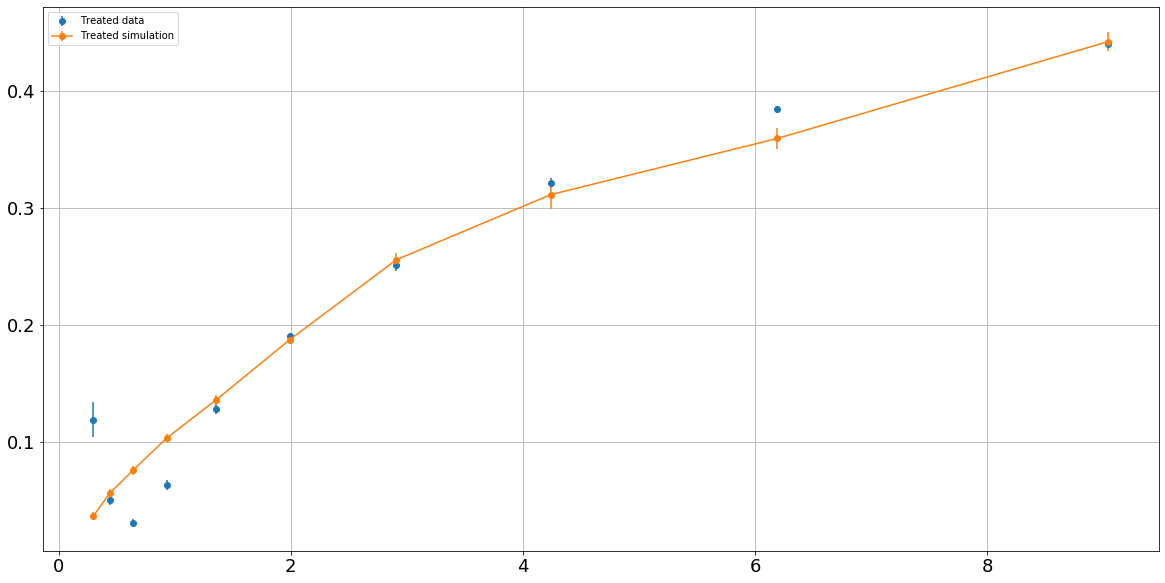

In [19]:
imin = 0
imax = 10

# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_full.csv" % (datapath),sep=";")
data = data.loc[data["Treatment"] == 0.5]
stress,el,el_err = data.values[imin:imax,[1,2,3]].T

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

shearrate = stress / (nuP * rhoP)

treated_samples = np.zeros((shearrate.shape[0],x_train.shape[1]))

treated_samples[:,:-1] = np.array([110,395,3.5])
treated_samples[:,-1] = shearrate

treated_qoi = np.empty(shearrate.shape[0])
treated_std = np.empty(shearrate.shape[0])
for n in range(treated_qoi.size):
    treated_qoi[n],treated_std[n] = predictionModel(treated_samples[n][None,:],return_std=True)

plt.figure(figsize=(20,10))

plt.errorbar(stress,el,yerr=el_err,fmt='o',label="Treated data")
plt.errorbar(stress,treated_qoi,yerr=treated_std,fmt='o-',label="Treated simulation")

plt.grid(True)
plt.legend()

plt.show()

## TMCMC sampling

In [20]:
# Set global sampling variables
method = "TMCMC"
lmax = 1
nburn = 10
cellHealth = "treated"
useMeasurementErr = True

if cellHealth == "healthy":
    imin = 2
    imax = 8
elif cellHealth == "treated":
    imin = 4
    imax = 10

# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_full.csv" % (datapath),sep=";")

if cellHealth == "healthy":
    data = data.loc[data["Treatment"] == 0]
elif cellHealth == "treated":
    data = data.loc[data["Treatment"] == 0.5]

stress,el,el_err = data.values[imin:imax,[1,2,3]].T

if useMeasurementErr:
    errType = "EL_error"
else:
    errType = "no_EL_error"
    el_err = np.zeros(el_err.shape)

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

print(data)

    Treatment  Stress (pa)     EL  EL error (+/-)
0         0.5         0.30  0.119           0.015
1         0.5         0.44  0.050           0.004
2         0.5         0.64  0.031           0.003
3         0.5         0.93  0.063           0.004
4         0.5         1.36  0.128           0.004
5         0.5         1.99  0.190           0.003
6         0.5         2.91  0.251           0.005
7         0.5         4.24  0.321           0.004
8         0.5         6.19  0.384           0.003
9         0.5         9.04  0.440           0.003
10        0.5        13.20  0.487           0.002
11        0.5        19.28  0.523           0.004
12        0.5        28.15  0.554           0.002
13        0.5        41.10  0.581           0.002
14        0.5        60.00  0.605           0.001


In [21]:
# Seed used for computational model sampling in paper
np.random.seed(7773777)

# Second test seed
#np.random.seed(123456)

nsamples = 100000

model_params = ["kLink","kBend","viscosityRatio"]
error_params = ["err"]
design_vars = ["shearrate"]

# Full parameter set
params = model_params + error_params

# Compute the shear rates
shearrate = stress / (nuP * rhoP)

# Map model errors to data samples
error_mapping = ["err" for n in range(shearrate.shape[0])]

# Construct problem dict
problem = {"model_type":"python",
           "evaluate":evaluate_GP,
           "model_params":model_params,
           "error_params":error_params,
           "design_vars":design_vars,
           "input_data":shearrate,
           "output_data":el,
           "data_errors":el_err,
           "error_mapping":error_mapping,
           "model_prior":(lambda sample: model_prior(sample,1)),
           "model_sampler":(lambda n: model_sampler(n,1)),
           "error_prior":error_prior,
           "error_sampler":error_sampler
          }

# Run Inverse UQ
TMCMC_sampler = TMCMC.TMCMC(problem,lmax=lmax,nburn=nburn,logpath=None,logstep=1e6)
df,qoi,c_err = TMCMC_sampler.sample(nsamples)

print(df)

Initializing...


100%|██████████| 100000/100000 [05:21<00:00, 311.50it/s]


Current max likelihood: 595073329.5861129
Calculating p for stage 1...
p: 0.011524586656902393
COV: 1.0000000017056652
Running stage 1...
Maximum chain length: 1


100%|██████████| 1100000/1100000 [1:27:17<00:00, 210.02it/s]


Current max likelihood: 714041741.6236725
Calculating p for stage 2...
p: 0.06400318437392462
COV: 0.9999999968460836
Running stage 2...
Maximum chain length: 1


100%|██████████| 1100000/1100000 [1:34:03<00:00, 194.92it/s] 


Current max likelihood: 832652011.5497268
Calculating p for stage 3...
p: 0.2468564904491223
COV: 0.9999999980420315
Running stage 3...
Maximum chain length: 1


100%|██████████| 1100000/1100000 [1:33:35<00:00, 195.87it/s] 


Current max likelihood: 857805219.0136582
Calculating p for stage 4...
p: 0.6018388797531109
COV: 0.9999999909970173
Running stage 4...
Maximum chain length: 1


100%|██████████| 1100000/1100000 [1:31:47<00:00, 199.74it/s]


Current max likelihood: 870360245.9591335
Calculating p for stage 5...
p: 1.0
COV: 0.7462248299412196
Running stage 5...
Maximum chain length: 1


100%|██████████| 1100000/1100000 [1:44:13<00:00, 175.90it/s] 


Current max likelihood: 869058549.729802
Sampling finished :)
            kLink       kBend  viscosityRatio       err    likelihood  \
0      106.662128  278.839393        5.219368  0.086706  5.173783e+06   
1      136.939386  192.749704        1.065022  0.054643  2.067741e+07   
2       94.069598  351.850271        5.109123  0.044503  1.100335e+07   
3       88.908965  365.187616        5.806643  0.064771  5.902176e+06   
4      137.079488  268.110243        1.141989  0.040004  1.369551e+08   
...           ...         ...             ...       ...           ...   
99995  133.866052  342.484352        1.683128  0.056403  4.670674e+07   
99996  116.501111  276.921157        3.287991  0.034986  5.612389e+07   
99997  114.734894  349.066048        3.219238  0.036362  2.359646e+08   
99998  127.418710  283.295351        1.615538  0.081514  1.995305e+07   
99999  122.213834  387.401022        1.892382  0.028338  7.342690e+08   

          prior  
0      0.000007  
1      0.000007  
2      

In [22]:

# Save output
df.to_csv("%s/%s_%s_%s_%s_samples_visc_%i_%i_lmax_%s_nburn_%i_nsamples_%i.csv" % 
          (outputpath,method,modelType,cellHealth,errType,imin,imax,lmax,nburn,nsamples),sep=";",index=False)

np.save("%s/%s_%s_%s_%s_qoi_visc_%i_%i_lmax_%s_nburn_%i_nsamples_%i.npy" % 
        (outputpath,method,modelType,cellHealth,errType,imin,imax,lmax,nburn,nsamples),qoi)

np.save("%s/%s_%s_%s_%s_c_err_visc_%i_%i_lmax_%s_nburn_%i_nsamples_%i.npy" % 
        (outputpath,method,modelType,cellHealth,errType,imin,imax,lmax,nburn,nsamples),c_err)


## Analyze results

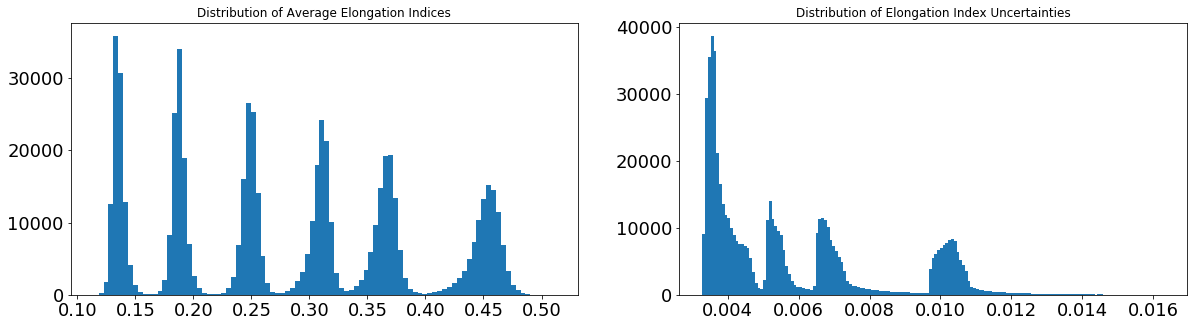

In [23]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.title("Distribution of Average Elongation Indices")
plt.hist(qoi.flatten(),bins='auto')

plt.subplot(1,2,2)
plt.title("Distribution of Elongation Index Uncertainties")
plt.hist(c_err.flatten(),bins='auto')
plt.show()

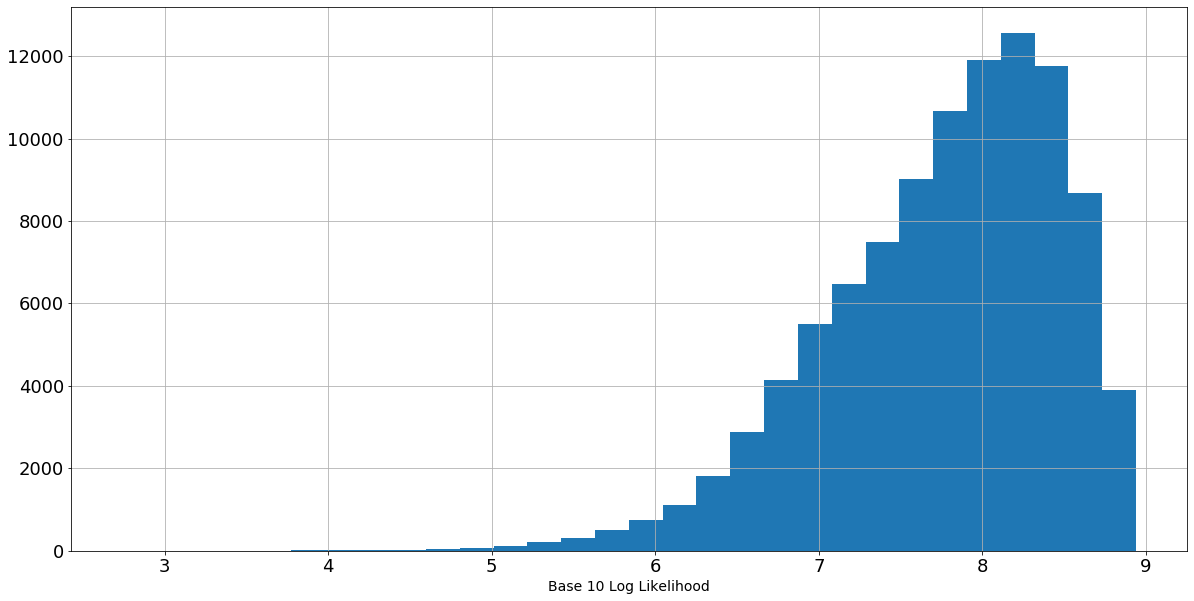

In [24]:
nbins = 30
plt.figure(figsize=(20,10))
plt.grid(True)

if method == "TMCMC":
    plt.xlabel(r"Base 10 Log Likelihood",fontsize=14)
    plt.hist(np.log10(df["likelihood"].values),bins=nbins)
    
plt.show()

In [25]:
if method == "TMCMC":
    for n in range(-10,16):
        print("Number of high densities larger than %e:" % (10**n),np.sum(df["likelihood"].values > 10**n))

Number of high densities larger than 1.000000e-10: 100000
Number of high densities larger than 1.000000e-09: 100000
Number of high densities larger than 1.000000e-08: 100000
Number of high densities larger than 1.000000e-07: 100000
Number of high densities larger than 1.000000e-06: 100000
Number of high densities larger than 1.000000e-05: 100000
Number of high densities larger than 1.000000e-04: 100000
Number of high densities larger than 1.000000e-03: 100000
Number of high densities larger than 1.000000e-02: 100000
Number of high densities larger than 1.000000e-01: 100000
Number of high densities larger than 1.000000e+00: 100000
Number of high densities larger than 1.000000e+01: 100000
Number of high densities larger than 1.000000e+02: 100000
Number of high densities larger than 1.000000e+03: 99999
Number of high densities larger than 1.000000e+04: 99976
Number of high densities larger than 1.000000e+05: 99816
Number of high densities larger than 1.000000e+06: 98097
Number of high den

Best sample:
kLink             1.221804e+02
kBend             3.809155e+02
viscosityRatio    2.026569e+00
err               2.506429e-02
likelihood        8.690585e+08
prior             7.108381e-06
Name: 33596, dtype: float64


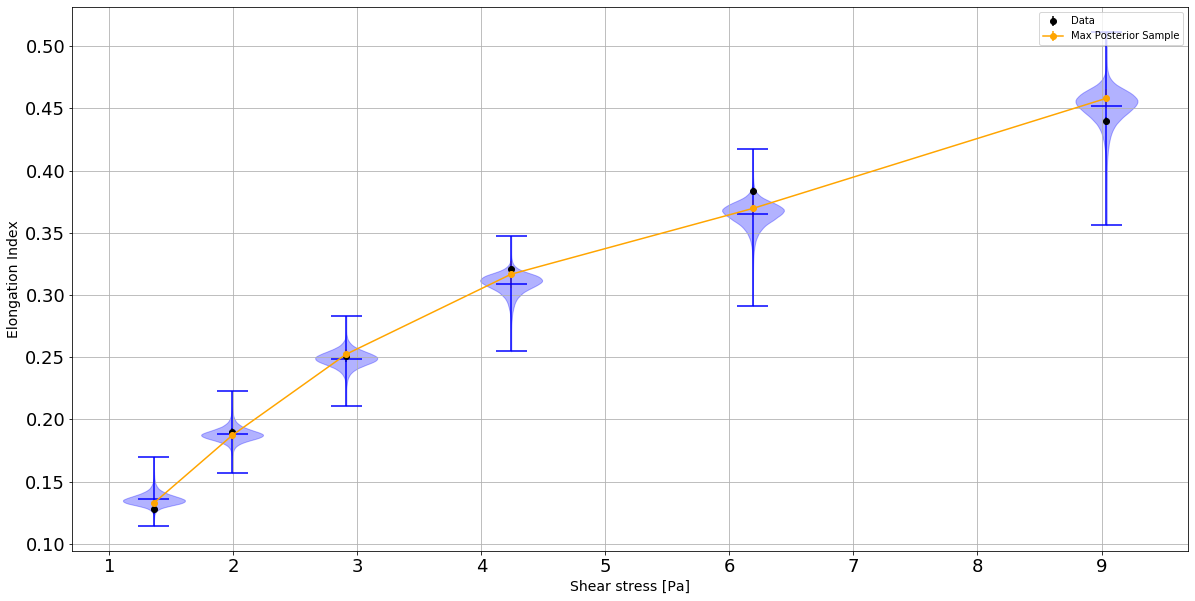

In [26]:
violin_color = "blue"
mpe_color = "orange"
data_color = "black"

plt.figure(figsize=(20,10))
plt.xlabel("Shear stress [Pa]",fontsize=14)
plt.ylabel("Elongation Index",fontsize=14)

plt.grid(True)

# Data
plt.errorbar(stress,el,yerr=el_err,fmt="o",color=data_color,label="Data")

# Highest likelihood
if method == "TMCMC":
    mle = np.argmax(df["likelihood"].values)
    mpe = np.argmax(df["likelihood"].values * df["prior"].values)
    #print("Max likelihood:",sample_df["likelihood"].values[mle])
elif method == "ABCSubSim":
    mle = np.argmin(df["distance"].values)
    #print("Minimum distance:",sample_df["distance"].values[mle])

print("Best sample:")
print(df.loc[mpe])
    
#plt.errorbar(stress,qoi[mle],c_err[mle],fmt="o-",label="Max Likelihood Sample")
plt.errorbar(stress,qoi[mpe],c_err[mpe],fmt="o-",color=mpe_color,label="Max Posterior Sample")

# Mean QoI output
mean = np.mean(qoi,axis=0)
var = np.sum((qoi - mean[None,:])**2,axis=0) / (qoi.shape[0] - 1)
conf = 1.96 * np.sqrt(var / qoi.shape[0])

ptile = np.percentile(qoi,[2.5,97.5],axis=0)

ptile[0] = mean - ptile[0]
ptile[1] -= mean

#plt.errorbar(stress,mean,yerr=ptile,fmt="o-",label="Mean QoI")

violin_parts = plt.violinplot(qoi,stress,showmeans=True)

for partname in ['cbars','cmins','cmaxes','cmeans']:
    vp = violin_parts[partname]
    vp.set_edgecolor(violin_color)

for vp in violin_parts["bodies"]:
    vp.set_facecolor(violin_color)
    vp.set_edgecolor(violin_color)

plt.legend()
plt.show()

In [27]:
"""
plt.figure(figsize=(20,10))
plt.xlabel("Shear stress [Pa]",fontsize=14)
plt.ylabel("Elongation Index",fontsize=14)

plt.grid(True)

# Plot all qoi
for n in range(qoi.shape[0]):
    plt.plot(stress,qoi[n])

# Data
plt.errorbar(stress,el,yerr=el_err,fmt="o",label="Data")
    
plt.legend()

plt.show()
"""

'\nplt.figure(figsize=(20,10))\nplt.xlabel("Shear stress [Pa]",fontsize=14)\nplt.ylabel("Elongation Index",fontsize=14)\n\nplt.grid(True)\n\n# Plot all qoi\nfor n in range(qoi.shape[0]):\n    plt.plot(stress,qoi[n])\n\n# Data\nplt.errorbar(stress,el,yerr=el_err,fmt="o",label="Data")\n    \nplt.legend()\n\nplt.show()\n'

## Parameter distributions in 1D

KDE maximum of kLink: 124.31313583927567
KDE maximum of kBend: 378.64867693168435
KDE maximum of viscosityRatio: 1.3904546540840126
KDE maximum of err: 0.03549196672010379


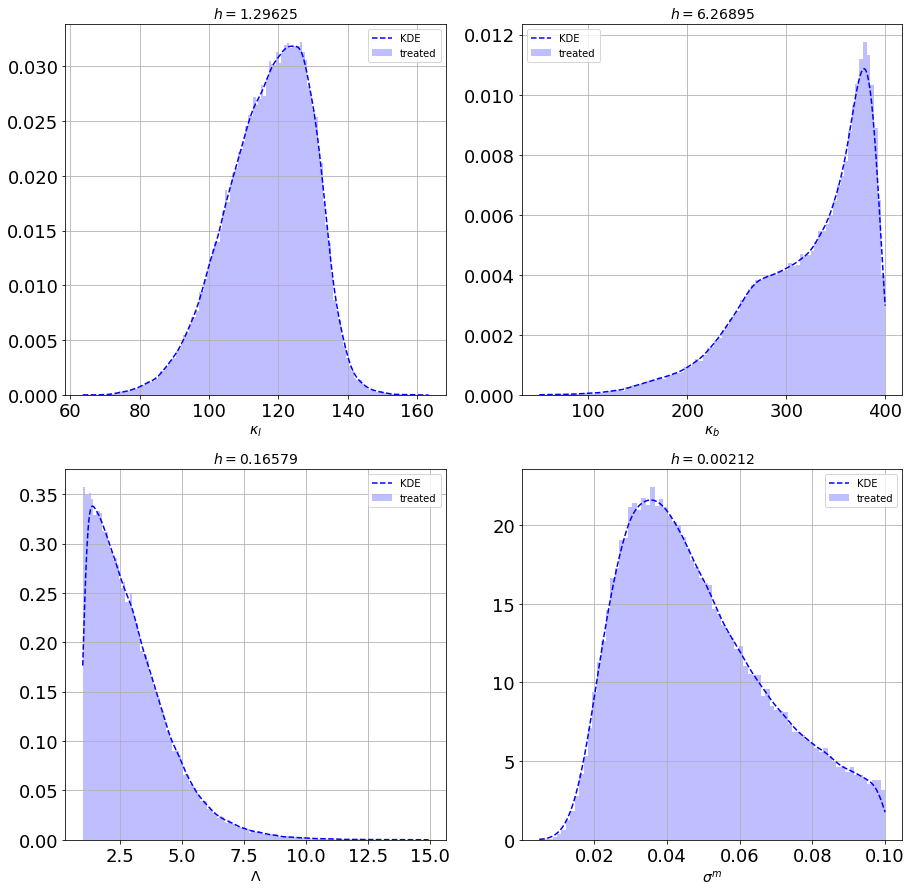

In [28]:
color = "blue"

plt.figure(figsize=(15,15))
for n in range(len(params)):
    vals = df[params[n]].values
    
    kde = sm.nonparametric.KDEMultivariate(data=vals,var_type="c",bw="normal_reference")
    
    x_vals = np.linspace(np.min(vals),np.max(vals),1000)
    y_vals = kde.pdf(x_vals)
    
    print("KDE maximum of",params[n]+":",x_vals[np.argmax(y_vals)])
    
    plt.subplot(2,2,n+1)
    plt.title(r"$h = %.5f$" % kde.bw,fontsize=14)
    plt.grid(True)
    plt.xlabel(names[params[n]],fontsize=14)
    plt.hist(df[params[n]].values,color=color,bins="auto",density=True,alpha=0.25,label=cellHealth)
    plt.plot(x_vals,y_vals,'--',color=color,label="KDE")
    plt.legend()
    
plt.show()

## Plot parameters in 2D

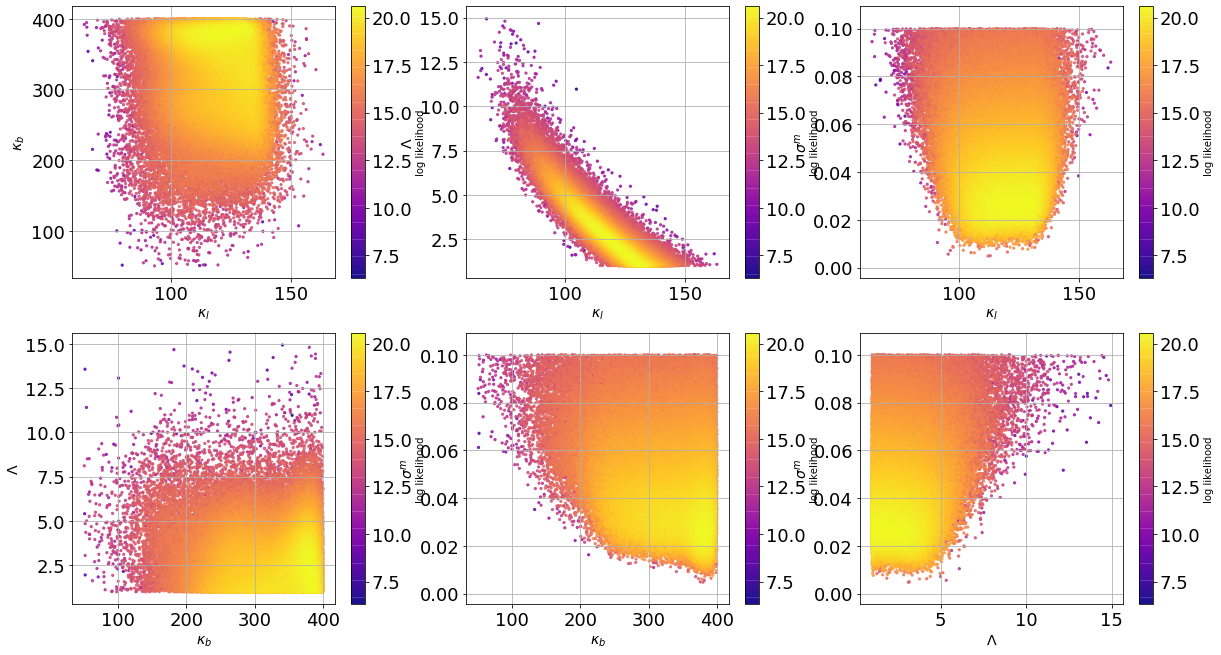

In [29]:
plt.figure(figsize=(20,11))

count = 1
s=5
for n in range(len(params)):
    for m in range(n,len(params)):
        if n != m:
            plt.subplot(2,3,count)
            plt.grid(True)
            plt.xlabel(names[params[n]],fontsize=14)
            plt.ylabel(names[params[m]],fontsize=14)
            if method == "TMCMC":
                order = np.argsort(df["likelihood"])
                plt.scatter(df[params[n]].values[order],df[params[m]].values[order],
                            s=s,c=np.log(df["likelihood"].values[order]),cmap="plasma",alpha=0.8)
                
            elif method == "ABCSubSim":
                order = np.argsort(df["distance"])[::-1]
                plt.scatter(df[params[n]].values[order],df[params[m]].values[order],
                            s=s,c=df["distance"].values[order],cmap="inferno")
                
            plt.colorbar(label="log likelihood")
            count += 1

plt.show()

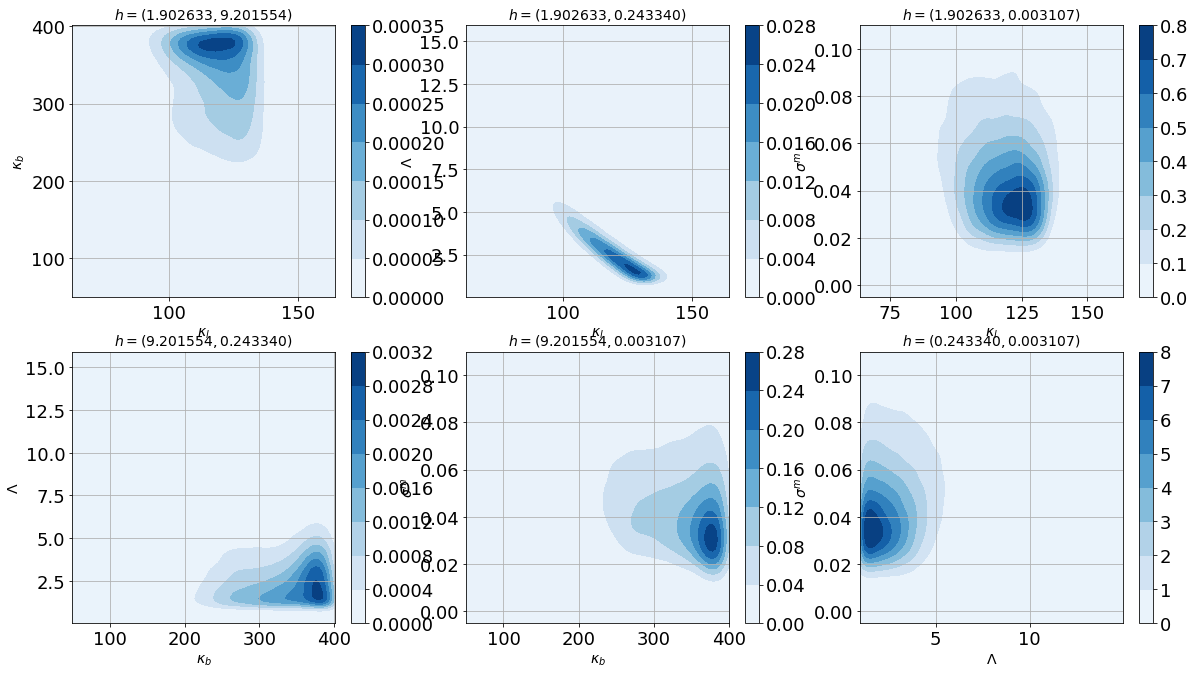

In [30]:
cmap = "Blues"

plt.figure(figsize=(20,11))

zoom = [1.0,1.0,0.01,
        1.0,0.01,0.01]

count = 1
for n in range(len(params)):
    for m in range(n,len(params)):
        if n != m:
            vals = df[[params[n],params[m]]].values
            
            kde = sm.nonparametric.KDEMultivariate(data=vals,var_type="cc",bw="normal_reference")
            
            x = np.linspace(np.min(vals[:,0])-zoom[count-1],np.max(vals[:,0])+zoom[count-1],100)
            y = np.linspace(np.min(vals[:,1])-zoom[count-1],np.max(vals[:,1])+zoom[count-1],100)
            xx,yy = np.meshgrid(x,y)
            
            grid_flat = np.column_stack([xx.flatten(),yy.flatten()])
            grid_vals = kde.pdf(grid_flat).reshape(xx.shape)
            
            plt.subplot(2,3,count)
            plt.title(r"$h = (%f,%f)$" % tuple(kde.bw),fontsize=14)
            plt.grid(True)
            plt.xlabel(names[params[n]],fontsize=14)
            plt.ylabel(names[params[m]],fontsize=14)
            plt.contourf(xx,yy,grid_vals,cmap=cmap)
            plt.colorbar()
            count += 1

plt.show()